In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import hashlib

from scipy.ndimage import maximum_filter
from scipy.ndimage import generate_binary_structure, iterate_structure


In [ ]:
file_path = "Songs/labon_ko.mp3"  


In [21]:
audio, sr = librosa.load(
    file_path,
    sr=11025,
    mono=True
)

print("Sample rate:", sr)
print("Audio length:", len(audio))


Sample rate: 11025
Audio length: 3788288


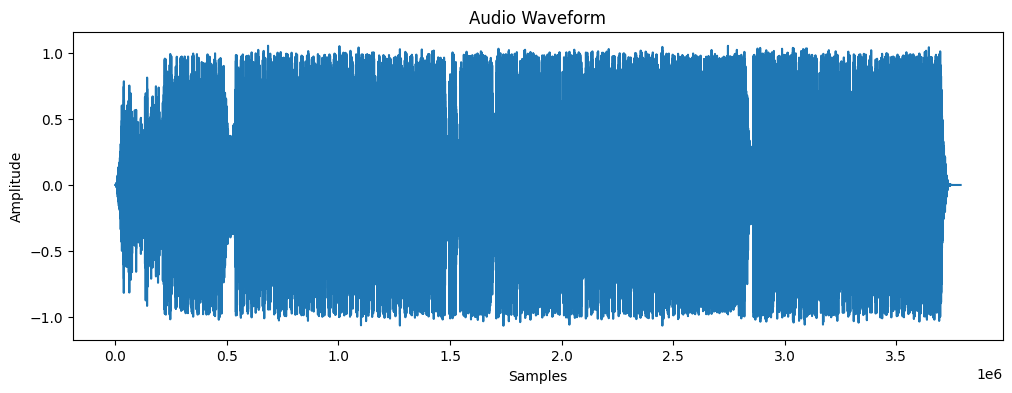

In [22]:
plt.figure(figsize=(12,4))
plt.plot(audio)
plt.title("Audio Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [23]:
spectrogram = np.abs(
    librosa.stft(
        audio,
        n_fft=2048,
        hop_length=512
    )
)

print("Spectrogram shape:", spectrogram.shape)


Spectrogram shape: (1025, 7400)


In [24]:
spectrogram_db = librosa.amplitude_to_db(
    spectrogram,
    ref=np.max
)

print("Converted to dB scale")


Converted to dB scale


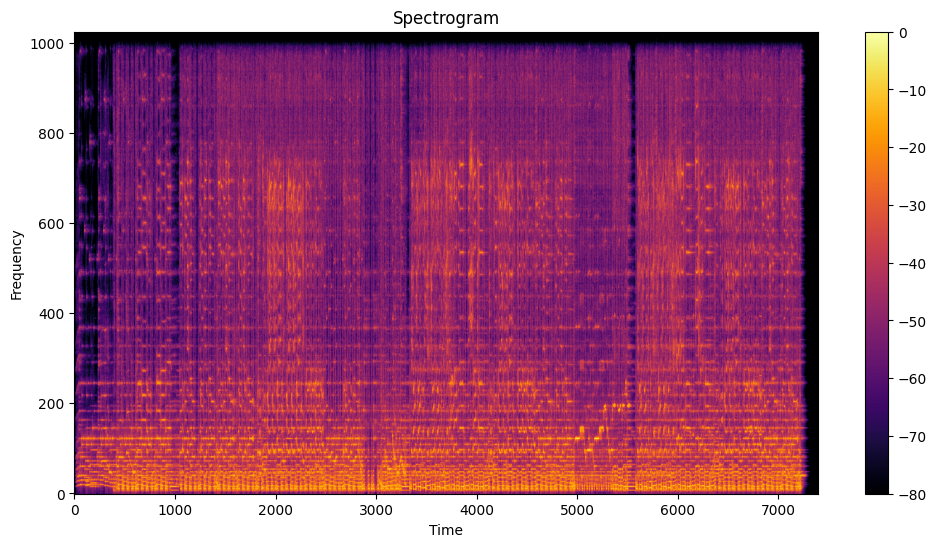

In [25]:
plt.figure(figsize=(12,6))

plt.imshow(
    spectrogram_db,
    aspect="auto",
    origin="lower",
    cmap="inferno"
)

plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")

plt.colorbar()

plt.show()


In [26]:
structure = generate_binary_structure(2, 1)

neighborhood = iterate_structure(
    structure,
    20
)

print("Neighborhood structure created")


Neighborhood structure created


In [27]:
local_max = maximum_filter(
    spectrogram_db,
    footprint=neighborhood
) == spectrogram_db

print("Local max shape:", local_max.shape)


Local max shape: (1025, 7400)


In [28]:
amp_min = -40

detected_peaks = local_max & (spectrogram_db > amp_min)

print("Threshold applied")


Threshold applied


In [29]:
peaks = np.argwhere(detected_peaks)

print("Number of peaks found:", len(peaks))
print("First 10 peaks:\n", peaks[:10])


Number of peaks found: 5522
First 10 peaks:
 [[  11 3972]
 [  11 6221]
 [  12  446]
 [  12  479]
 [  12  541]
 [  12  589]
 [  12  613]
 [  12  637]
 [  12  685]
 [  12  733]]


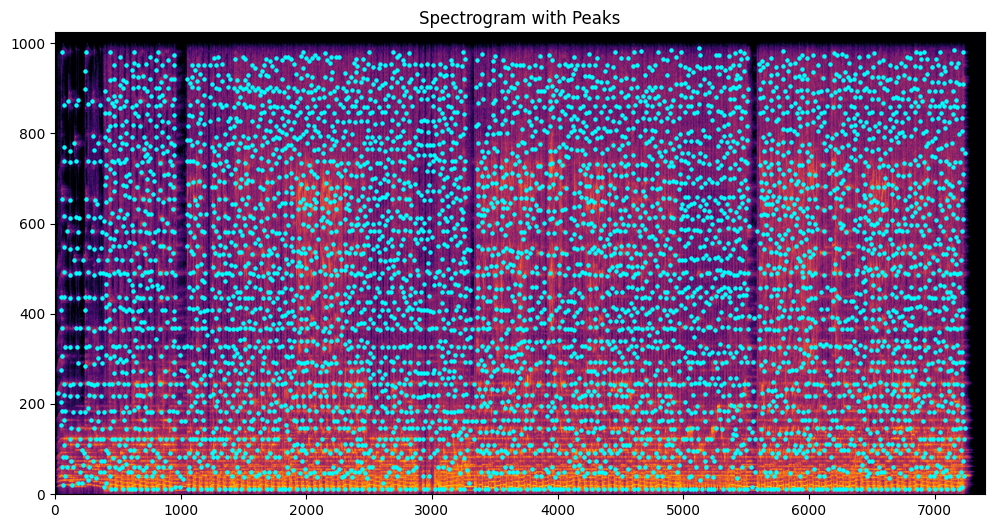

In [30]:
plt.figure(figsize=(12,6))

plt.imshow(
    spectrogram_db,
    aspect="auto",
    origin="lower",
    cmap="inferno"
)

plt.scatter(
    peaks[:,1],
    peaks[:,0],
    color="cyan",
    s=5
)

plt.title("Spectrogram with Peaks")

plt.show()


In [31]:
peaks_sorted = sorted(
    peaks,
    key=lambda x: x[1]
)

print("Peaks sorted")


Peaks sorted


In [32]:
fan_value = 15

fingerprints = []

for i in range(len(peaks_sorted)):

    for j in range(1, fan_value):

        if i + j < len(peaks_sorted):

            freq1 = peaks_sorted[i][0]
            time1 = peaks_sorted[i][1]

            freq2 = peaks_sorted[i+j][0]
            time2 = peaks_sorted[i+j][1]

            delta_time = time2 - time1

            if 0 < delta_time <= 200:

                hash_input = f"{freq1}|{freq2}|{delta_time}"

                hash_output = hashlib.sha1(
                    hash_input.encode()
                ).hexdigest()[0:20]

                fingerprints.append(
                    (hash_output, time1)
                )

print("Number of fingerprints:", len(fingerprints))


Number of fingerprints: 69693


In [33]:
print("First 10 fingerprints:\n")

for fp in fingerprints[:10]:
    print(fp)


First 10 fingerprints:

('88fa1985342309b08249', np.int64(23))
('0cd65b0a2c54064120fd', np.int64(23))
('7f1087934d7cb2efd015', np.int64(23))
('321065c6af86f9d4c8dd', np.int64(23))
('d3926d4c6b38250eff36', np.int64(23))
('77df84b5f52587593d66', np.int64(23))
('a4c095ae71a5d94ce579', np.int64(23))
('54e61948372646855125', np.int64(23))
('7ff8764102d0f6340780', np.int64(23))
('5e2166e49830644535b8', np.int64(23))


In [34]:
import os

folder_path = "saved_fingerprint"
print("Folder ready:", folder_path)

Folder ready: saved_fingerprint


In [36]:
song_name = "labon_ko"

finger_print_path = f"saved_fingerprint/{song_name}.npy"

np.save(finger_print_path, fingerprints)
